# 2.0.0: Model performance

Let's take a look at how our different models perform. There are quite a few models to compare, so there are a few ways we can visualize and assess performance.

For instance, we trained models for each of 33 traits for 3 "trait sets" (i.e. the provenance of the gridded trait data: sPlot-only, GBIF-only, and sPlot + GBIF combined). Below we will explore both general, trait set-level trends as well as zoom in on 8 traits specifically to assess trait-level trends.

## Imports and config

In [1]:
from pathlib import Path

import pandas as pd

from src.conf.conf import get_config
from src.conf.environment import log

cfg = get_config()

## Model performance across all traits and trait sets

Collect the trait model directories and load one model to familiarize with the results DataFrame structure.

In [2]:
from src.utils.dataset_utils import get_latest_run, get_models_dir

model_dirs = [
    d for d in get_models_dir().glob("*") if d.is_dir() and d.name.startswith("X")
]

pd.read_csv(
    get_latest_run(model_dirs[0] / "autogluon") / "splot" / "evaluation_results.csv",
    index_col=0,
    header=[0, 1],
)

root_mean_squared_error           mean_squared_error            \
                         mean       std               mean       std   
index                                                                  
0                   -0.368086  0.012683          -0.135616  0.009276   

      mean_absolute_error                  r2            pearsonr            \
                     mean       std      mean       std      mean       std   
index                                                                         
0               -0.204339  0.004746  0.166738  0.039199  0.414134  0.039704   

      median_absolute_error           norm_root_mean_squared_error            
                       mean       std                         mean       std  
index                                                                         
0                 -0.140822  0.005529                     -0.20829  0.011431

Aggregate the performance statistics of all trait models for all trait sets into a master results DataFrame.

In [3]:
def aggregate_results() -> pd.DataFrame:
    """One df to rule them all."""
    model_dirs = [
        d for d in get_models_dir().glob("*") if d.is_dir() and d.name.startswith("X")
    ]

    results = []
    for model_dir in model_dirs:
        trait_id = model_dir.name
        run_dir = get_latest_run(model_dir / "autogluon")
        for trait_set in [d for d in run_dir.glob("*") if d.is_dir()]:
            trait_set_name = trait_set.name
            df = pd.read_csv(
                trait_set / cfg.train.eval_results, index_col=0, header=[0, 1]
            ).reset_index(drop=True)

            df.index = pd.MultiIndex.from_tuples(
                [(trait_id, trait_set_name)], names=["trait_id", "trait_set"]
            )
            results.append(df)
    
    return pd.concat(results)

results = aggregate_results()
results.head(6)

root_mean_squared_error           mean_squared_error  \
                                        mean       std               mean   
trait_id  trait_set                                                         
X163_mean splot                    -0.368086  0.012683          -0.135616   
          gbif                     -0.420192  0.014170          -0.176722   
          splot_gbif               -0.375389  0.012784          -0.141048   
X27_mean  splot                    -2.016579  0.157927          -4.086543   
          gbif                     -2.335387  0.160611          -5.474669   
          splot_gbif               -2.072859  0.165621          -4.318687   

                               mean_absolute_error                  r2  \
                           std                mean       std      mean   
trait_id  trait_set                                                      
X163_mean splot       0.009276           -0.204339  0.004746  0.166738   
          gbif        0.011693           -0.291559  0.011715 -0.085262   
          splot_gbif  0.009504           -0.225392  0.006673  0.133546   
X27_mean  splot       0.632074           -1.442928  0.126860  0.265491   
          gbif        0.753288           -1.601680  0.146086  0.015250   
          splot_gbif  0.686592           -1.453772  0.137980  0.224240   

                                pearsonr           median_absolute_error  \
                           std      mean       std                  mean   
trait_id  trait_set                                                        
X163_mean splot       0.039199  0.414134  0.039704             -0.140822   
          gbif        0.030400  0.288524  0.030736             -0.240633   
          splot_gbif  0.034698  0.393044  0.036042             -0.168700   
X27_mean  splot       0.062661  0.517037  0.059662             -1.044294   
          gbif        0.057820  0.313109  0.058655             -1.065891   
          splot_gbif  0.062974  0.481721  0.063871             -1.034581   

                               norm_root_mean_squared_error            
                           std                         mean       std  
trait_id  trait_set                                                    
X163_mean splot       0.005529                    -0.208290  0.011431  
          gbif        0.009732                    -0.237682  0.010543  
          splot_gbif  0.008107                    -0.212406  0.011207  
X27_mean  splot       0.106359                    -0.188465  0.011826  
          gbif        0.138393                    -0.218256  0.010693  
          splot_gbif  0.114903                    -0.193686  0.011628

Define a few helper functions to allow us to use human-readable trait names and units instead of only trait IDs as defined in the TRY database.

In [4]:
import json
import re


def get_trait_number_from_id(trait_id: str) -> str:
    """Parses the trait number from a trait id string."""
    tnum = re.search(r"\d+", trait_id)
    if tnum is None:
        raise ValueError(f"Could not extract trait number from {trait_id}")
    return tnum.group()


def get_trait_name_from_id(trait_id: str, length: str = "short") -> tuple[str, str]:
    """Returns the name of a trait from its id as well as the unit of the trait."""
    with open(cfg.trait_mapping) as f:
        mapping = json.load(f)

    tnum = get_trait_number_from_id(trait_id)

    if tnum not in mapping:
        raise ValueError(f"Trait number {tnum} not in mapping")

    if length not in mapping[tnum]:
        raise ValueError(f"Length {length} not in mapping for trait {trait_id}")

    return mapping[tnum][length], mapping[tnum]["unit"]


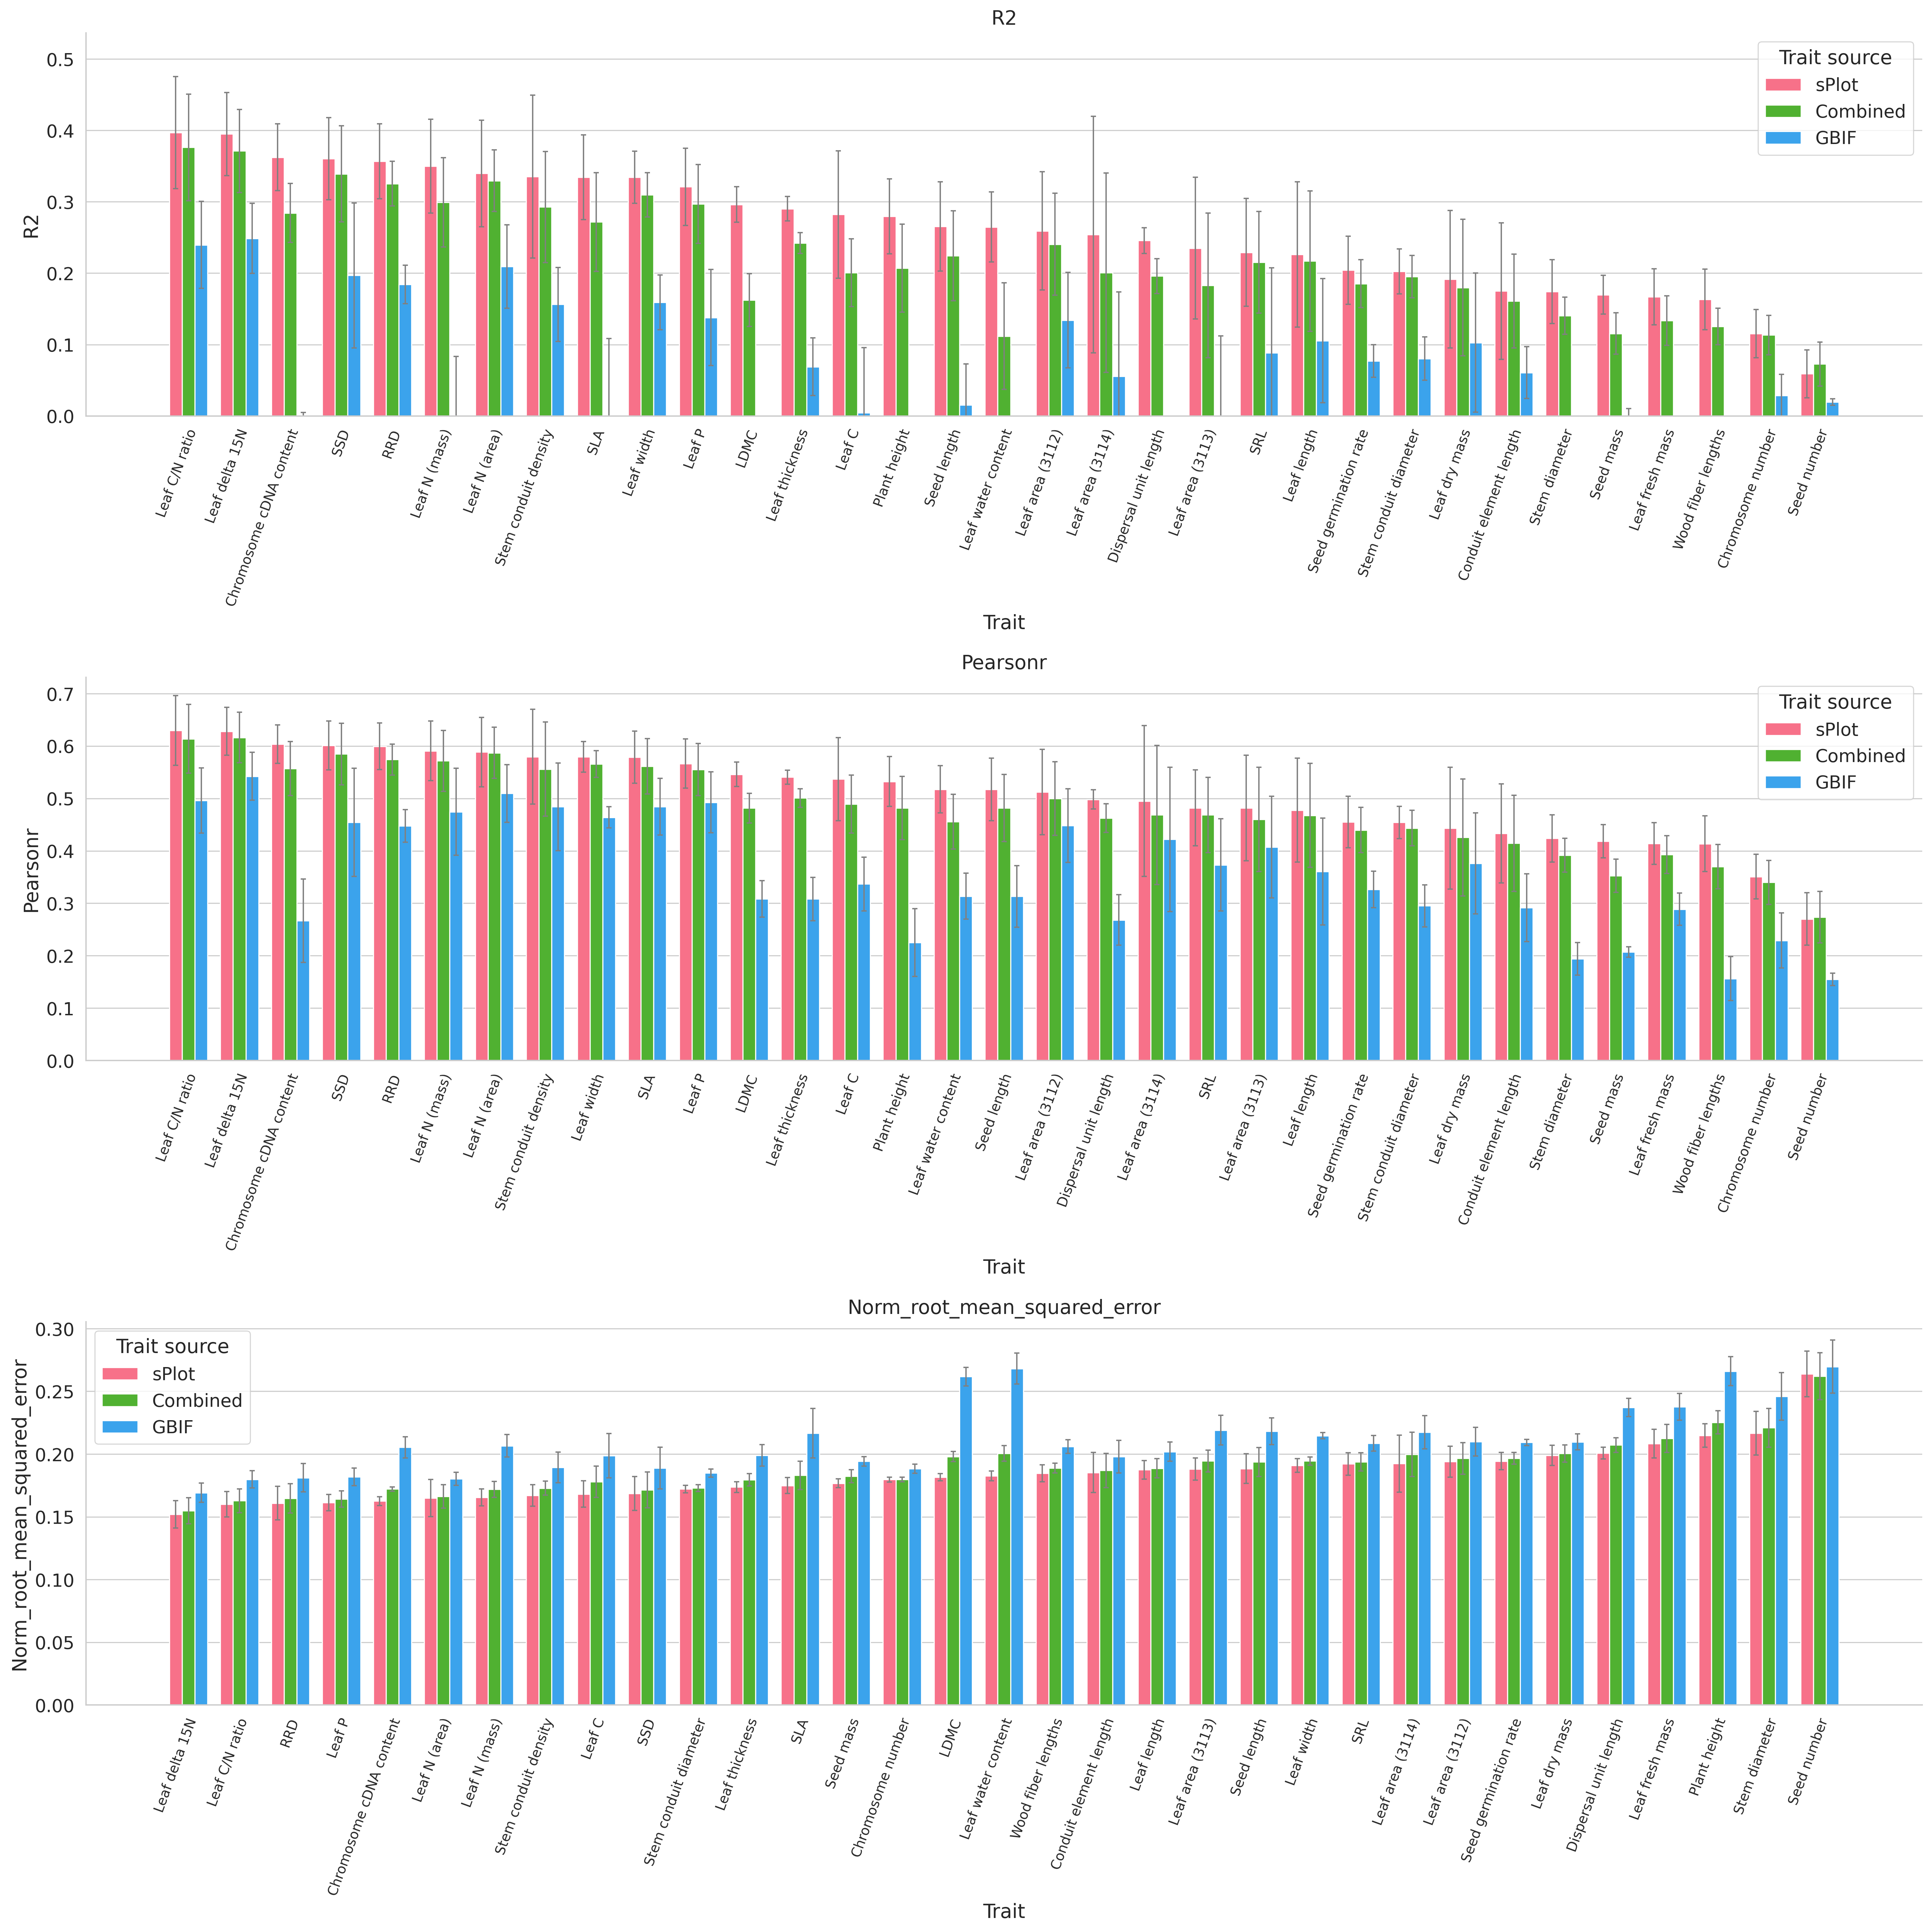

In [29]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Prepare data
treatments = ["splot", "splot_gbif", "gbif"]
metrics = ["r2", "pearsonr", "norm_root_mean_squared_error"]

# Set the color palette for treatments
colors = sns.color_palette("husl", len(treatments))
color_dict = dict(zip(treatments, colors))

with sns.plotting_context("paper", font_scale=1.5), sns.axes_style("whitegrid"):
    # Create subplots for each metric
    fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(20, 20), dpi=300)

    for idx, metric in enumerate(metrics):
        traits = (
            results.sort_values(by=(metric, "mean"), ascending=False)
            .index.get_level_values("trait_id")
            .unique()
        )
        ax = axs[idx]

        # Prepare data for the current metric
        data = []
        for trait_id in traits:
            trait_name = get_trait_name_from_id(trait_id)[0]
            for treatment in treatments:
                mean_value = results.loc[(trait_id, treatment), (metric, "mean")]
                std_value = results.loc[(trait_id, treatment), (metric, "std")]

                if metric == "norm_root_mean_squared_error":
                    mean_value = abs(mean_value)

                data.append([trait_name, treatment, mean_value, std_value])

        df = pd.DataFrame(
            data, columns=["trait_name", "treatment", "mean_value", "std_value"]
        )

        # Create bar plot with error bars
        bar_width = 0.3  # Bar width
        gap = 0.3  # Gap between groups of bars
        x = np.arange(len(traits)) * (len(treatments) * bar_width + gap)

        error_kw = {
            "elinewidth": 1,  # Error bar thickness
            "ecolor": "grey",  # Error bar color
            "capsize": 2,  # Cap size for error bars
        }

        def map_treatment(treatment: str) -> str:
            if treatment == "splot":
                return "sPlot"
            if treatment == "splot_gbif":
                return "Combined"
            if treatment == "gbif":
                return "GBIF"
            else:
                raise ValueError(f"Unknown treatment {treatment}")

        for i, treatment in enumerate(treatments):
            subset = df[df["treatment"] == treatment]
            ax.bar(
                x + i * bar_width,
                subset["mean_value"],
                yerr=subset["std_value"],
                width=bar_width,
                label=map_treatment(treatment),
                color=color_dict[treatment],
                error_kw=error_kw,
            )

        ax.set_title(f"{metric.capitalize()}")
        ax.set_xlabel("Trait")
        ax.set_ylabel(metric.capitalize())
        ax.set_xticks(
            (x + bar_width * (len(treatments) - 1) / 2) - 0.05,
            [get_trait_name_from_id(t)[0] for t in traits],
            rotation=70,
            ha="right",
            va="top",
            rotation_mode="anchor",
            fontsize=10
        )
        # ax.set_xticklabels([get_trait_name_from_id(t)[0] for t in traits], rotation=90)
        ax.legend(title="Trait source")

        # Set y-axis limits for R²
        if metric == "r2":
            ax.set_ylim(0)

        sns.despine()
        ax.grid(False, axis="x")

    plt.tight_layout()
    plt.show()

## Feature importance

## Area of Applicability